## Imports

In [ ]:
import sklearn
sklearn.__file__


In [50]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import math
import collections
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import cosine
import time

import numpy as np
import umap
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram

from pprint import pprint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)
plt.rcParams['figure.figsize'] = [15, 5]

## Construção da Base de Dados

In [2]:
# PEGA PATH DE TODAS IMAGENS E COLOCA NUM ARRAY
all_paths = []
classes = listdir('./natural_images_100/')

for root, dirs, files in os.walk('./natural_images_100/'):
    for d in dirs:
        for f in listdir(root + d):
            all_paths.append(root + d + '/' + f)
# classes

In [3]:
# COLOCA TDS IMAGENS EM UM ARRAY DE IMAGENS PIL 224x224
all_images = np.empty(len(all_paths), dtype=object)
for n in range(0, len(all_paths)):
    all_images[n] = image.load_img(all_paths[n], target_size=(224, 224))


In [4]:
def print_image(all_images_index):
    img = all_images[all_images_index]
    plt.imshow(img)
    plt.show()
    plt.close()

## Criando o modelo

In [6]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
# model.summary()

94773248/94765736 [==============================] - 46s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

In [7]:
# calculating to all features
# SALVA ARRAY DE FEATURES EM UM GRANDE ARRAY PARA TDS FEATURES
all_features = np.empty((len(all_images), model._nested_outputs.shape[1]))
feature_list_np = []
feature_list = []

for i in range(len(all_images)):
    x = image.img_to_array(all_images[i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    feature_list_np.append(np.array(features))
    feature_list.append((np.array(features)).flatten())

    for feature in features:
        all_features[i] = feature

In [8]:
print(np.shape(all_features))
print(np.shape(all_features[0]))
print()
print(np.shape(feature_list))
print(np.shape(feature_list[0]))

(800, 2048)
(2048,)

(800, 2048)
(2048,)


In [ ]:
all_features

In [ ]:
feature_list

In [ ]:
# printa features da primeira imagem
len(all_features)
pprint(all_features[0])
for a in all_features:
    print(a)

In [ ]:
# Verificando shape e tipo das features da prmeira imagem
print(all_features[0].shape, features.dtype, '\n')

# Mostrando as features.
pprint(features[0])

In [ ]:
# COMPARA DUAS IMAGENS PARECIDAS PRA VALIDAR A AS FEATURES
distance = cosine(feature_list[0], feature_list[2])
print(distance)
print_image(0)
print_image(2)

# 2 Aplicação de Algoritmos de Agrupamento de Dados

### 2.1 Partitioning-based

In [18]:
# Inicializa Dataframe para plotar resultados
images_transformed = umap.UMAP(n_neighbors=5).fit_transform(all_features.data)
df = pd.DataFrame(images_transformed, columns=['x', 'y'])

/home/bruna/anaconda3/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


### 2.1.a - Kmeans

In [28]:
kmeans = KMeans(n_clusters=len(classes), random_state=0).fit(np.array(np.array(feature_list)))
print('Inércia do Kmeans: ', kmeans.inertia_)

Inércia do Kmeans:  502813.8793668305


In [29]:
df_kmeans = df
df_kmeans['label'] = kmeans.labels_
df_kmeans.head()

,x,y,label
0,11.459993,-8.223529,2
1,11.683399,-7.304152,2
2,11.179287,-8.539153,2
3,10.370728,-8.291084,2
4,10.418664,-8.170319,2


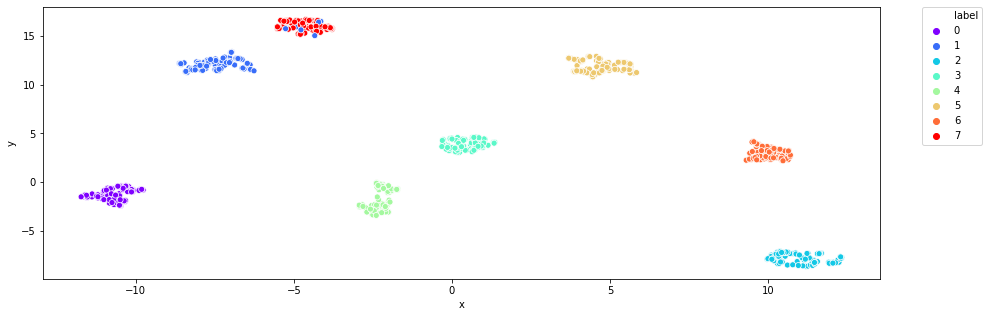

In [30]:
_ = sns.scatterplot(x='x', y='y', data=df_kmeans, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### 2.1.b - KMedoids

In [34]:
kmedoids = KMedoids(n_clusters=len(classes), random_state=0).fit(feature_list)
print('Inércia do KMedoids: ', kmedoids.inertia_)
print(kmedoids.labels_)
# reduced_data = PCA(n_components=len(classes)).fit_transform(feature_list)
# print(dir(reduced_data))

Inércia do KMedoids:  25259.21
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 3 6 3 6 3 3 3 6 6 6 6 3 3 6 3 3 6 3 6 6
 6 6 3 6 6 3 6 6 3 6 6 3 3 3 3 6 3 3 6 6 6 6 3 6 3 6 3 3 3 3 3 3 6 6 6 3 3
 3 3 3 3 6 6 3 6 3 3 3 6 3 3 3 6 6 6 6 3 6 3 3 3 6 3 6 3 3 6 6 3 3 3 3 3 3
 3 6 6 3 3 3 3 3 3 3 6 6 3 6 3 6 3 6 6 6 3 3 3 3 3 3 3 3 3 3 3 6 6 3 6 3 3
 3 3 3 3 6 6 3 6 6 6 6 3 3 3 6 6 6 6 3 3 6 1 3 3 3 6 6 3 3 4 3 3 3 3 3 3 3
 6 3 3 3 6 3 3 6 3 1 3 4 3 3 4 3 3 3 3 6 6 3 6 3 3 3 3 6 6 3 3 3 3 3 3 3 3
 6 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 

In [36]:
df_kmedoids = df
df_kmedoids['label'] = kmedoids.labels_
df_kmedoids.head()


,x,y,label
0,11.459993,-8.223529,0
1,11.683399,-7.304152,0
2,11.179287,-8.539153,0
3,10.370728,-8.291084,0
4,10.418664,-8.170319,0


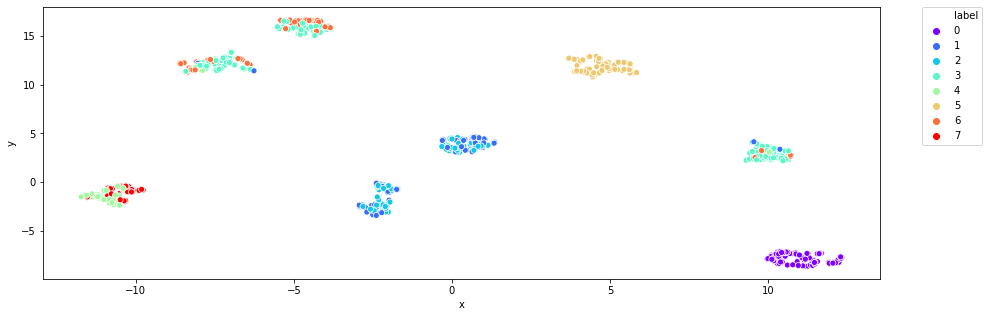

In [37]:
_ = sns.scatterplot(x='x', y='y', data=df_kmedoids, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### 2.1.c - Mini Batch KMeans

In [38]:
miniBatchKmeans = MiniBatchKMeans(n_clusters=len(classes), random_state=0).fit(feature_list)

print('Inércia do Mini Batch Kmeans: {}\n'.format(miniBatchKmeans.inertia_))
print('Labels: ', miniBatchKmeans.labels_)


Inércia do Mini Batch Kmeans: 505009.2214249524

Labels:  [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 7 7 7
 7 7 7 7 0 7 7 7 5 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

In [39]:
df_miniBatchKmeans = df
df_miniBatchKmeans['label'] = miniBatchKmeans.labels_
df_miniBatchKmeans.head()


,x,y,label
0,11.459993,-8.223529,4
1,11.683399,-7.304152,4
2,11.179287,-8.539153,4
3,10.370728,-8.291084,4
4,10.418664,-8.170319,4


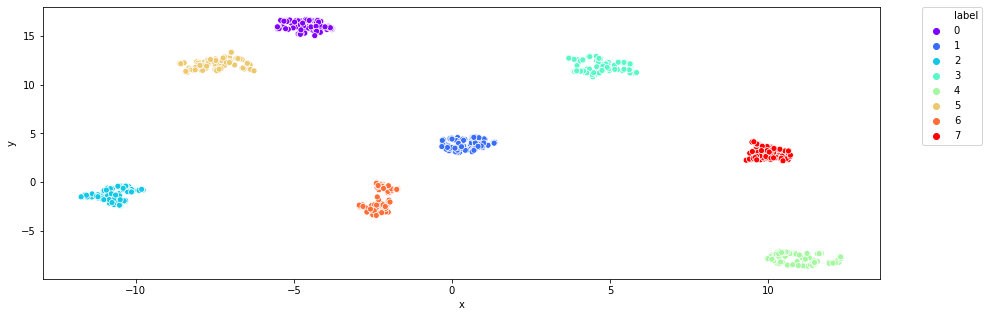

In [40]:
_ = sns.scatterplot(x='x', y='y', data=df_miniBatchKmeans, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### 2.2 Hierarchical-based

### 2.2.a Hierarchical Agglomerative Clustering - Single Linkage

In [45]:
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
Z = ward(pdist(feature_list))
clusters = fcluster(Z, t=0.9, criterion='distance')


array([218, 236, 278, 300, 297, 267, 295, 247, 254, 202, 225, 284, 239,
       237, 298, 291, 205, 289, 207, 277, 226, 272, 301, 293, 261, 275,
       264, 230, 227, 232, 266, 282, 215, 212, 269, 258, 216, 220, 229,
       268, 255, 234, 273, 223, 279, 299, 209, 224, 283, 274, 276, 217,
       260, 249, 252, 253, 296, 235, 290, 222, 265, 208, 271, 211, 246,
       251, 259, 242, 243, 287, 206, 288, 280, 262, 281, 294, 203, 244,
       285, 248, 286, 240, 210, 256, 238, 219, 241, 270, 214, 221, 250,
       263, 228, 245, 213, 231, 233, 292, 204, 257, 473, 494, 451, 478,
       440, 433, 483, 481, 474, 434, 453, 488, 402, 497, 400, 449, 430,
       467, 438, 417, 447, 441, 444, 479, 459, 463, 464, 431, 436, 425,
       484, 460, 470, 403, 498, 426, 418, 457, 486, 420, 461, 410, 475,
       414, 469, 437, 412, 477, 448, 446, 406, 422, 465, 454, 416, 421,
       413, 489, 458, 455, 456, 443, 407, 462, 427, 432, 435, 439, 411,
       428, 445, 491, 480, 493, 485, 487, 496, 423, 466, 495, 47

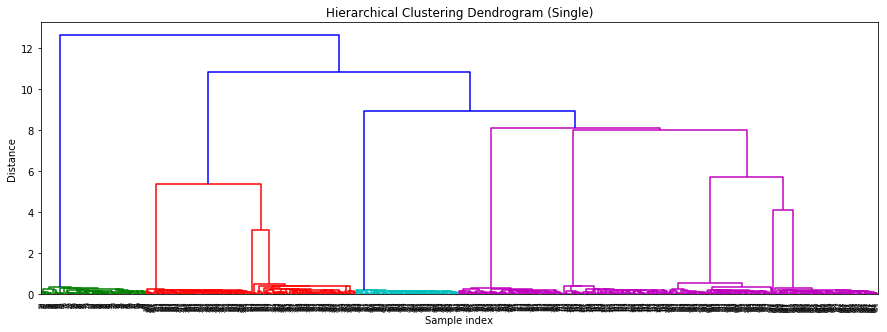

In [68]:
df_single = df
linkage_matrix_single = linkage(df_single, method='single')
plt.title('Hierarchical Clustering Dendrogram (Single)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
d = dendrogram(linkage_matrix_single)


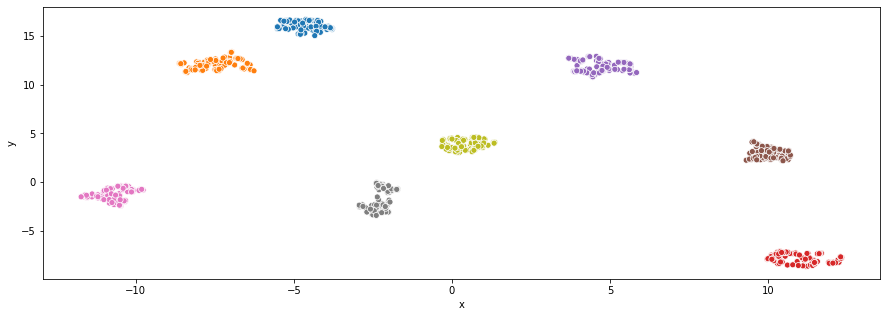

In [62]:
labels = fcluster(linkage_matrix_single, 1.6, 'distance')
df_single['cluster_labels'] = labels
_ = sns.scatterplot(x='x', y='y', data=df_single, hue='cluster_labels', palette='tab10', legend=False)

### 2.2.b Hierarchical Agglomerative Clustering - Complete Linkage

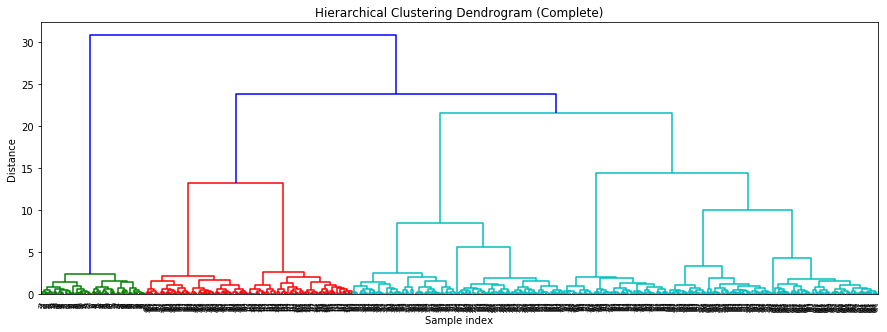

In [71]:
df_complete = df
linkage_matrix_complete = linkage(df_complete, method='complete')
plt.title('Hierarchical Clustering Dendrogram (Complete)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
d = dendrogram(linkage_matrix_complete)

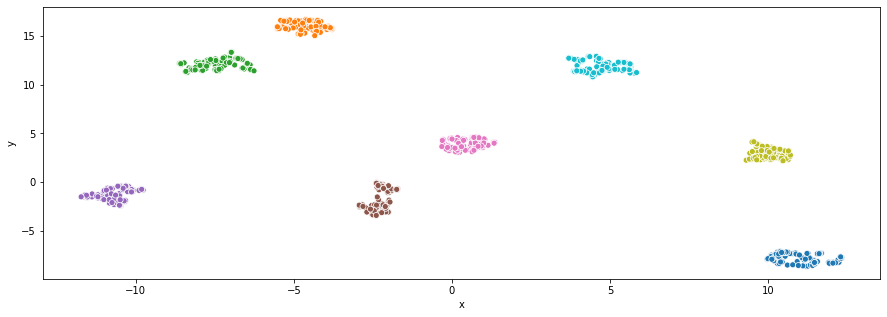

In [72]:
df_complete['cluster_labels'] = labels
_ = sns.scatterplot(x='x', y='y', data=df_complete, hue='cluster_labels', palette='tab10', legend=False)

### 2.2.c Hierarchical Agglomerative Clustering - Average Linkage

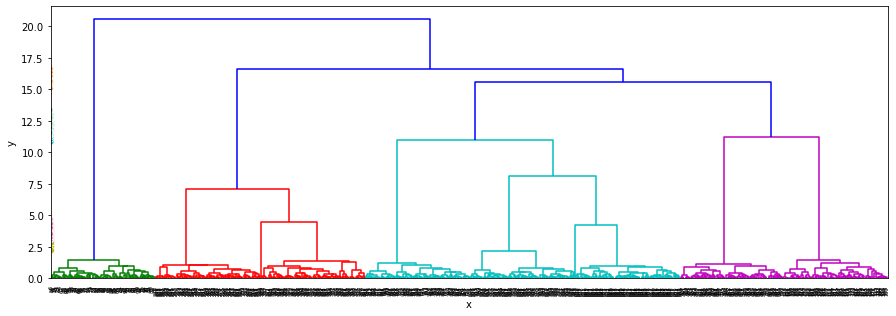

In [64]:
df_average = df
linkage_matrix = linkage(df_average, method='average')
d = dendrogram(linkage_matrix)

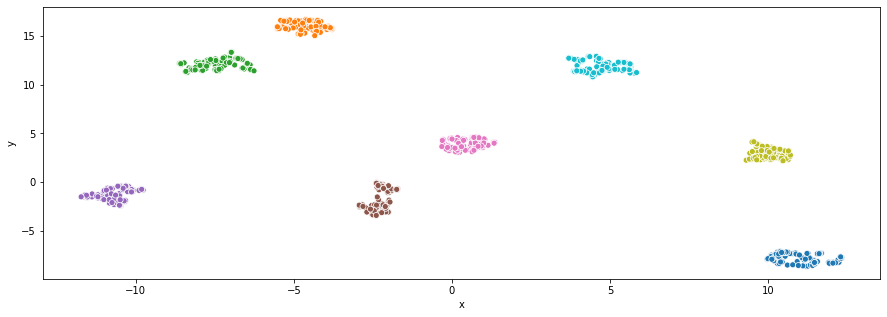

In [65]:
labels = fcluster(linkage_matrix, 3.5, 'distance')
df_average['cluster_labels'] = labels
_ = sns.scatterplot(x='x', y='y', data=df_average, hue='cluster_labels', palette='tab10', legend=False)


### Density-based

In [ ]:
#  sklearn.cluster.DBSCAN

### Grid-based

### Model-based

# 3 Avaliação do resultado dos agrupamentos de dados

### Interno

### Externo

### Relativo